In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


In [2]:
df_wo = pd.read_excel('./WOs.xlsx', sheet_name = 'Sheet1', engine='openpyxl')

In [3]:
df_asset = pd.read_excel('./WOs.xlsx', sheet_name = 'assettype')
df_wotype = pd.read_excel('./WOs.xlsx', sheet_name = 'WOType')
df_location = pd.read_excel('./WOs.xlsx', sheet_name = 'location')
df_status = pd.read_excel('./WOs.xlsx', sheet_name = 'status')

In [4]:
df_wo2 = df_wo.copy()
df_wo2.head(10)

,Site ID,Asset Number,Asset Description,assettype,assetcriticality,installdate,location,WO Number,WO Description,reportdate,WO Status,WO Type,WO Priority,Labor Hours,Labor Cost,Material Cost,Work Order Cost,pump station
0,PS,2003425,Truck #2003425,TRUCK,NaN,NaT,PS,PS2706551,Weekly Vehicle Inspection #2003425- Weekly,2016-04-27 08:41:55,CLOSE,PM,3.0,0.500000,14.60,0.00,14.60,NaN
1,PS,2003425,Truck #2003425,TRUCK,NaN,NaT,CENTRAL,PS2695726,Weekly Vehicle Inspection #2003425- Weekly,2015-12-01 11:13:18,CLOSE,PM,3.0,0.500000,14.60,0.00,14.60,NaN
2,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,X-DECOMMI,PS2444244,Remove Verbatim and components,2014-11-13 10:28:29,CLOSE,MOD,3.0,1.250000,36.50,0.00,36.50,NaN
3,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS715889,7193429 Providence crossing ARV,2011-07-22 09:48:18,CLOSE,PM,3.0,6.100000,172.97,21.71,194.68,ABBERRONE
4,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS273993,ALARM CALL-SHORELAKE w/o#6153503,2010-06-16 09:07:04,CLOSE,OCAL,3.0,3.000000,100.26,0.00,100.26,ABBERRONE
5,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS348575,831101,2010-08-03 10:16:32,CLOSE,CM,3.0,0.000000,0.00,0.00,0.00,ABBERRONE
6,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS262798,MOBILE TEST,2010-02-25 10:27:41,CLOSE,PM,3.0,0.000000,0.00,0.00,0.00,ABBERRONE
7,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS653871,62229,2011-06-22 17:49:49,CLOSE,CM,3.0,3.033333,86.03,0.00,86.03,ABBERRONE
8,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS2030915,Aberrone - False Generator Running alarms thro...,2013-11-08 14:08:46,CLOSE,CM,2.0,3.166667,89.78,0.00,89.78,ABBERRONE
9,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS2411950,Mission High Level Mineral Ridge,2014-09-30 14:32:22,CLOSE,OCAL,2.0,0.500000,14.60,0.00,14.60,ABBERRONE


In [5]:
#remove rows with no pump stations
df_wo2 =df_wo2[(df_wo2['pump station'].notna())]

In [6]:
df_wo2.shape

(341719, 18)

In [7]:
#location data with longitude and latitude
loc_lookup = pd.read_csv(r"Location_v3.csv",encoding='ISO-8859-1')
loc_lookup.head(5)

,long,lat,Pump_Identifier,pump station,Pump Station Address Final,long_lat
0,-83.961629,33.969770,1,Winder Hwy Lawrenceville GA,Winder Hwy Lawrenceville GA,"(-83.9616285, 33.9697702)"
1,-83.945564,34.085553,2,ABBERONE,ABBERRONE,"(-83.9455640476, 34.08555339)"
2,-83.945564,34.085553,2,ABBERRONE,ABBERRONE,"(-83.9455640476, 34.08555339)"
3,-83.998518,33.853074,3,ABINGTON DRIVE,ABINGTON DRIVE,"(-83.9985179404, 33.85307417)"
4,-83.940248,33.978324,4,ALCOVY RIVER,ALCOVY RIVER BOOSTER STATION,"(-83.9402479833, 33.97832391)"


In [8]:
num_null_values = loc_lookup['pump station'].isnull().sum()
num_null_values

0

In [9]:
#print(df_wo2.columns)
print(loc_lookup.columns)

Index(['long', 'lat', 'Pump_Identifier', 'pump station',
       'Pump Station Address Final', 'long_lat'],
      dtype='object')


In [10]:
#merge df and location file to get the lat and long
df_wo3 = df_wo2.merge(loc_lookup, on ='pump station', how = 'left')
df_wo3.head(5)

,Site ID,Asset Number,Asset Description,assettype,assetcriticality,installdate,location,WO Number,WO Description,reportdate,...,Labor Hours,Labor Cost,Material Cost,Work Order Cost,pump station,long,lat,Pump_Identifier,Pump Station Address Final,long_lat
0,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS715889,7193429 Providence crossing ARV,2011-07-22 09:48:18,...,6.100000,172.97,21.71,194.68,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)"
1,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS273993,ALARM CALL-SHORELAKE w/o#6153503,2010-06-16 09:07:04,...,3.000000,100.26,0.00,100.26,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)"
2,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS348575,831101,2010-08-03 10:16:32,...,0.000000,0.00,0.00,0.00,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)"
3,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS262798,MOBILE TEST,2010-02-25 10:27:41,...,0.000000,0.00,0.00,0.00,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)"
4,PS,ABB-ADR-P-001,ABBERRONE AUTO-DIALER,BUILDING,NaN,NaT,PS-10-036,PS653871,62229,2011-06-22 17:49:49,...,3.033333,86.03,0.00,86.03,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)"


In [11]:
df_wo3.shape

(341719, 23)

In [ ]:
loc_lookup['assetcriticality'] = loc_lookup['assetcriticality'].fillna(loc_lookup['Pump Station Address_raw data'])

In [13]:
null_sum = df_wo3['assetcriticality'].isnull().sum()
null_sum

74078

In [14]:
null_sum = df_wo3['location'].isnull().sum()
null_sum

0

In [15]:
null_sum = df_wo3['WO Type'].isnull().sum()
null_sum

286

In [16]:
null_sum = df_wo3['WO Priority'].isnull().sum()
null_sum

351

In [17]:
null_sum = df_wo3['WO Status'].isnull().sum()
null_sum

0

In [19]:
# Drop rows with NaN values from all columns
df_wo3 = df_wo3.dropna(how='any')
df_wo3.shape

(204152, 23)

#Convert NA to 0

df_wo3['assetcriticality'] = df_wo3['assetcriticality'].fillna(0)
df_wo3['location'] = df_wo3['location'].fillna(0)
df_wo3['WO Type'] = df_wo3['WO Type'].fillna(0)
df_wo3['WO Priority'] = df_wo3['WO Priority'].fillna(0)
df_wo3['WO Status'] = df_wo3['WO Status'].fillna(0)

#print(df_wo['assettype'].unique())
print(df_wo3['assetcriticality'].unique())
print(df_wo3['WO Type'].unique())
print(df_wo3['WO Priority'].unique())
print(df_wo3['WO Status'].unique())

In [22]:
#getting numerical values for some of the columns

df_wo3 = df_wo3.merge(df_asset, on = 'assettype', how = "inner")
df_wo3 = df_wo3.merge(df_wotype, on = 'WO Type', how = "inner")
df_wo3 = df_wo3.merge(df_location, on = 'location', how = "inner")
df_wo3 = df_wo3.merge(df_status, on = 'WO Status', how = "inner")

In [23]:

df_wo3.head(5)

,Site ID,Asset Number,Asset Description,assettype,assetcriticality,installdate,location,WO Number,WO Description,reportdate,...,pump station,long,lat,Pump_Identifier,Pump Station Address Final,long_lat,assettype_order,WOType_Order,location_order,WO Status_order
0,PS,ABB-ATS-P-001,"AUTOMATIC TRANSFER SWITCH, B010206432",SWITCH-TRANSFER,5.0,2014-09-29,PS-10-036,PS2868998,"ATS, Annual PM Inspection",2021-02-24 12:27:39,...,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)",4,1,4,3
1,PS,ABB-ATS-P-001,"AUTOMATIC TRANSFER SWITCH, B010206432",SWITCH-TRANSFER,5.0,2014-09-29,PS-10-036,PS2868999,Automatic Transfer Switch,2021-02-24 12:27:40,...,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)",4,1,4,3
2,PS,ABB-ATS-P-001,"AUTOMATIC TRANSFER SWITCH, B010206432",SWITCH-TRANSFER,5.0,2014-09-29,PS-10-036,PS2905040,"ATS, Annual PM Inspection",2022-02-22 13:28:29,...,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)",4,1,4,3
3,PS,ABB-ATS-P-001,"AUTOMATIC TRANSFER SWITCH, B010206432",SWITCH-TRANSFER,5.0,2014-09-29,PS-10-036,PS2905041,Automatic Transfer Switch,2022-02-22 13:28:30,...,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)",4,1,4,3
4,PS,ABB-ATS-P-001,"AUTOMATIC TRANSFER SWITCH, B010206432",SWITCH-TRANSFER,5.0,2014-09-29,PS-10-036,PS2939900,"ATS, ANNUAL PM INSPECTION",2023-01-24 15:12:47,...,ABBERRONE,-83.945564,34.085553,2.0,ABBERRONE,"(-83.9455640476, 34.08555339)",4,1,4,3


In [24]:
#check length
print(len(df_wo))
print(len(df_wo3))

356249
204152


In [25]:
df_wo3.columns.tolist()

['Site ID',
 'Asset Number',
 'Asset Description',
 'assettype',
 'assetcriticality',
 'installdate',
 'location',
 'WO Number',
 'WO Description',
 'reportdate',
 'WO Status',
 'WO Type',
 'WO Priority',
 'Labor Hours',
 'Labor Cost',
 'Material Cost',
 'Work Order Cost',
 'pump station',
 'long',
 'lat',
 'Pump_Identifier',
 'Pump Station Address Final',
 'long_lat',
 'assettype_order',
 'WOType_Order',
 'location_order',
 'WO Status_order']

In [26]:
##subset using relevant columns only

# y = WO Priority

df_new = df_wo3[[
#'Site ID',
 #'Asset Number',
 #'Asset Description',
 #'assettype',
 'WO Priority',
 #'location',
 'assetcriticality',
 #'installdate',
 #'WO Number',
 #'WO Description',
 #'reportdate',
 #'WO Status',
 #'WO Type',
 'Labor Hours',
 'Labor Cost',
 'Material Cost',
 'Work Order Cost',
 'assettype_order',
 'WOType_Order',
 'location_order',
 'WO Status_order'
    ]]

In [27]:
df_new.head(5)

,WO Priority,assetcriticality,Labor Hours,Labor Cost,Material Cost,Work Order Cost,assettype_order,WOType_Order,location_order,WO Status_order
0,3.0,5.0,1.25,39.43,0.0,39.43,4,1,4,3
1,3.0,5.0,0.00,0.00,0.0,0.00,4,1,4,3
2,3.0,5.0,1.00,34.06,0.0,34.06,4,1,4,3
3,3.0,5.0,0.00,0.00,0.0,0.00,4,1,4,3
4,3.0,5.0,1.00,34.06,0.0,34.06,4,1,4,3


In [28]:
df_new.dtypes

WO Priority         float64
assetcriticality    float64
Labor Hours         float64
Labor Cost          float64
Material Cost       float64
Work Order Cost     float64
assettype_order       int64
WOType_Order          int64
location_order        int64
WO Status_order       int64
dtype: object

In [29]:
print(df_new['assetcriticality'].unique())
print(df_new['WOType_Order'].unique())
print(df_new['WO Priority'].unique())
print(df_new['WO Status_order'].unique())
print(df_new['assettype_order'].unique())

[5. 4. 3. 2. 1.]
[ 1  3  4  5 11  8  2  9  6  7 12 14 13 15 10 16 18 19 17]
[3. 1. 2. 4. 5.]
[ 3  4  2  5  9 13  1 15 11 12  6 16 10 14  7  8]
[  4  12  20  27   6  16  19  30   5  10  17  26   8  28  21  24  31   2
   9  15  40  42  34  14   7  36  44  38  13   3  52  54  56  57  59  60
  18  48  46  37  61  23  77  41  70  45  65  78  50  29  62  63  22  68
  85  25  66 100  47 101  93  90  53  39  32 106 105 107  55  79  69  74
  75  49  80  88  96  81  82  67  94  72  71  83]


In [20]:
##creating training and testing datasets 

x_data = df_new.drop(['WO Priority'], axis=1)
y_data = df_new['WO Priority']
 


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.30, 
                                                            shuffle = True, random_state=614)
       

    
##scale training datasets

scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

    
#print(x_data)
#print(y_data)

In [23]:
#check the y values stats..class imbalanace issye since most belong to class 3

df_new.groupby('WO Priority')['WO Priority'].count() \
                                    .reset_index(name='count') \
                                    .sort_values(['count'], ascending=False)\
                                    .reset_index(drop = True)

,WO Priority,count
0,3.0,311169
1,1.0,13914
2,2.0,12421
3,4.0,3365
4,5.0,488
5,0.0,351


# Fit Models

## KNN ##

In [26]:
# https://stats.stackexchange.com/questions/534999/why-is-k-sqrtn-a-good-solution-of-the-number-of-neighbors-to-consider

k = 6 #using the exisiting # of priorities 

classifier = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
classifier.fit(scaled_x_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=6)

In [27]:
#predict on new dataset

y_pred = classifier.predict(scaled_x_test)

cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
ac = accuracy_score(y_test, y_pred)

In [28]:
print(classifier.classes_)

[0. 1. 2. 3. 4. 5.]


6


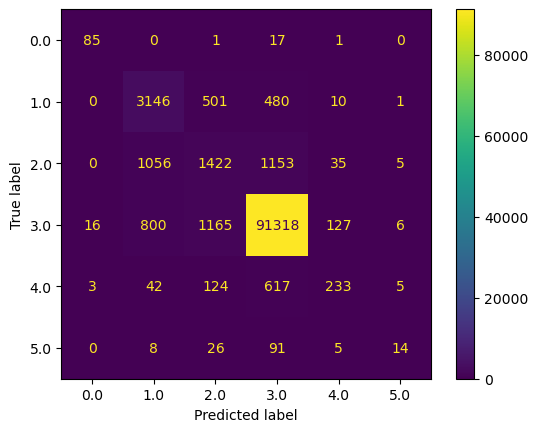

0.9385931540389999


In [29]:
print(k)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classifier.classes_)
disp.plot()
plt.show()
print(ac)

In [30]:
# calculate classification metrics
df_rpt = pd.DataFrame(precision_recall_fscore_support(y_test,y_pred)).transpose()
df_rpt.columns = columns=["precision","recall","f1-score","support"]
print("Classification Metrics:")
print(df_rpt)


Classification Metrics:
   precision    recall  f1-score  support
0   0.817308  0.817308  0.817308    104.0
1   0.622724  0.760271  0.684657   4138.0
2   0.439024  0.387360  0.411577   3671.0
3   0.974828  0.977374  0.976099  93432.0
4   0.566910  0.227539  0.324739   1024.0
5   0.451613  0.097222  0.160000    144.0


In [31]:
#balance accuracy is way less than regular accuracy. Therefore, it is a better metric to evaluate the model in case of imbalance.

balanced_acc = balanced_accuracy_score(y_test, y_pred)

print('Balanced accuracy:', balanced_acc)


Balanced accuracy: 0.544512325074858


# Handle class imbalance 

In [ ]:
#https://medium.com/mlearning-ai/handling-class-imbalance-in-machine-learning-cb1473e825ce
#https://imbalanced-learn.org/stable/ensemble.html
#https://eqibuana.medium.com/how-to-deal-with-imbalanced-data-in-classification-tasks-1046e5be0e0

## fit KNN models below using either undersample or oversample at a time

## 1) undersample

In [ ]:
#Apply RandomUnderSampler to the training data and testing datasets 

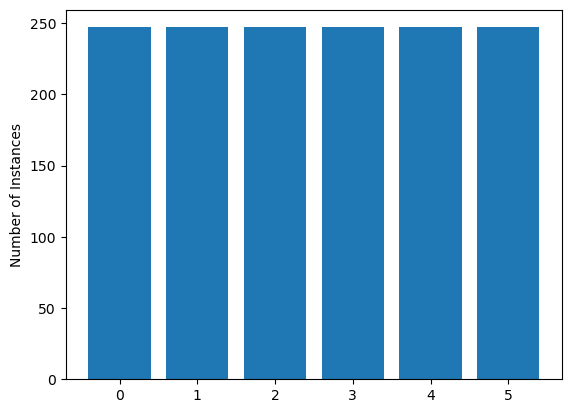

In [34]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(scaled_x_train, y_train)

# plot the new distribution
unique, counts = np.unique(y_train_resampled, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '1','2','3','4','5'])
plt.ylabel('Number of Instances')
plt.show()

In [37]:
X_train_resampled.shape, y_train_resampled.shape

((1482, 9), (1482,))

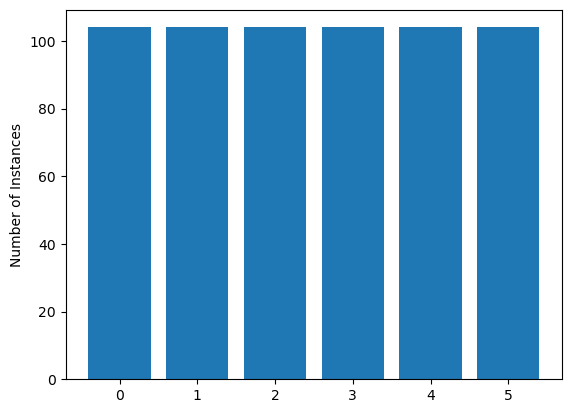

In [35]:
rus = RandomUnderSampler(random_state=42)
X_test_resampled, y_test_resampled = rus.fit_resample(scaled_x_test, y_test)

# plot the new distribution
unique, counts = np.unique(y_test_resampled, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '1','2','3','4','5'])
plt.ylabel('Number of Instances')
plt.show()

In [38]:
X_test_resampled.shape, y_test_resampled.shape

((624, 9), (624,))

## 2) oversample

In [33]:
#Apply SMOTE oversampling to the training data and testing datasets 

In [73]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np

# Assuming 'scaled_x_train' and 'y_train' are your original training data

# Step 1: Apply SMOTE oversampling to the training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(scaled_x_train, y_train)

# Step 2: Subset the resampled data to 15,000 rows for each class, totaling 100,000 rows
total_subset_size = 200000
subset_size_per_class = 30000

# Get unique classes and their counts after oversampling
counter = Counter(y_train_resampled)

# Initialize empty lists to store subsets
subsets_X = []
subsets_y = []

# Shuffle indices for each class
for cls in range(6):  # Assuming classes range from 0 to 5
    indices_cls = np.where(y_train_resampled == cls)[0]
    np.random.shuffle(indices_cls)

    # Take subset_size_per_class indices for each class
    indices = indices_cls[:subset_size_per_class]

    # Store the subset for the current class
    subsets_X.append(X_train_resampled[indices])
    subsets_y.append(y_train_resampled[indices])

# Concatenate subsets for all classes
X_train_resampled = np.concatenate(subsets_X)
y_train_resampled = np.concatenate(subsets_y)

# Now, X_subset and y_subset contain 15,000 rows for each class, totaling 100,000 rows after oversampling


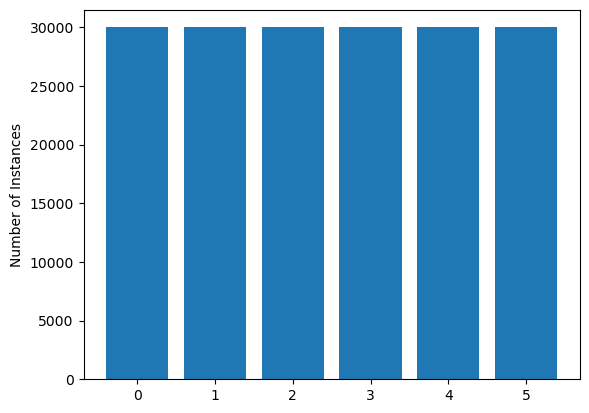

In [74]:
# plot the new distribution
unique, counts = np.unique(y_train_resampled, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '1','2','3','4','5'])
plt.ylabel('Number of Instances')
plt.show()

In [75]:
X_train_resampled.shape, y_train_resampled.shape

((180000, 9), (180000,))

In [76]:

from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np

# Assuming 'scaled_x_test' and 'y_test' are your original test data

# Step 1: Apply SMOTE oversampling to the test data
sm = SMOTE(random_state=42)
X_test_resampled, y_test_resampled = sm.fit_resample(scaled_x_test, y_test)

# Step 2: Subset the resampled data to 16,000 rows for each class, totaling 100,000 rows
total_subset_size = 200000
subset_size_per_class = 30000

# Get unique classes and their counts after oversampling
counter = Counter(y_test_resampled)

# Initialize empty lists to store subsets
subsets_X = []
subsets_y = []

# Shuffle indices for each class
for cls in range(6):  # Assuming classes range from 0 to 5
    indices_cls = np.where(y_test_resampled == cls)[0]
    np.random.shuffle(indices_cls)

    # Take subset_size_per_class indices for each class
    indices = indices_cls[:subset_size_per_class]

    # Store the subset for the current class
    subsets_X.append(X_test_resampled[indices])
    subsets_y.append(y_test_resampled[indices])

# Concatenate subsets for all classes
X_test_resampled = np.concatenate(subsets_X)
y_test_resampled = np.concatenate(subsets_y)

# Now, X_test_resampled and y_test_resampled contain 16,000 rows for each class, totaling 100,000 rows after oversampling


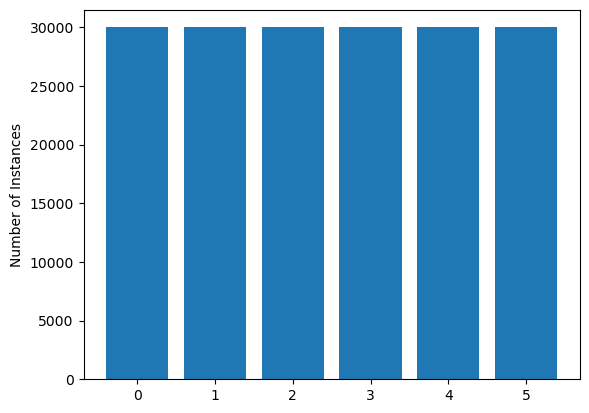

In [77]:
# plot the new distribution
unique, counts = np.unique(y_test_resampled, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1, 2, 3, 4, 5], ['0', '1','2','3','4','5'])
plt.ylabel('Number of Instances')
plt.show()

In [78]:
X_test_resampled.shape, y_test_resampled.shape

((180000, 9), (180000,))

## 1) fit KNN again

### Fitting KNN models again with either oversamples or undersamples

In [54]:
##fit KNN again
k=6

classifier = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
classifier.fit(X_train_resampled, y_train_resampled)


KNeighborsClassifier(metric='manhattan', n_neighbors=6)

In [55]:

y_pred = classifier.predict(X_test_resampled)

cm = confusion_matrix(y_test_resampled, y_pred, labels=classifier.classes_)
ac = accuracy_score(y_test_resampled, y_pred)

print(classifier.classes_)
print(cm)
print(ac)


[0. 1. 2. 3. 4. 5.]
[[47317   171   570   760   703   479]
 [    1 37056 11405   118  1104   316]
 [   34 15127 28060   848  4474  1457]
 [   38   718  1531 46594   903   216]
 [  237  2906  9285  8391 26103  3078]
 [  490  3433  8356  2486 10671 24564]]
0.69898


In [56]:
# calculate classification metrics
df_rpt = pd.DataFrame(precision_recall_fscore_support(y_test_resampled,y_pred)).transpose()
df_rpt.columns = columns=["precision","recall","f1-score","support"]
print("Classification Metrics:")
print(df_rpt)


Classification Metrics:
   precision   recall  f1-score  support
0   0.983374  0.94634  0.964502  50000.0
1   0.623723  0.74112  0.677372  50000.0
2   0.473930  0.56120  0.513886  50000.0
3   0.787101  0.93188  0.853393  50000.0
4   0.593817  0.52206  0.555631  50000.0
5   0.815809  0.49128  0.613257  50000.0


In [57]:
balanced_acc = balanced_accuracy_score(y_test_resampled, y_pred)

print('Balanced accuracy:', balanced_acc)


Balanced accuracy: 0.69898


## tune hyper parameters of KNN

Best N : 1
Best Score : 0.9245444444444445


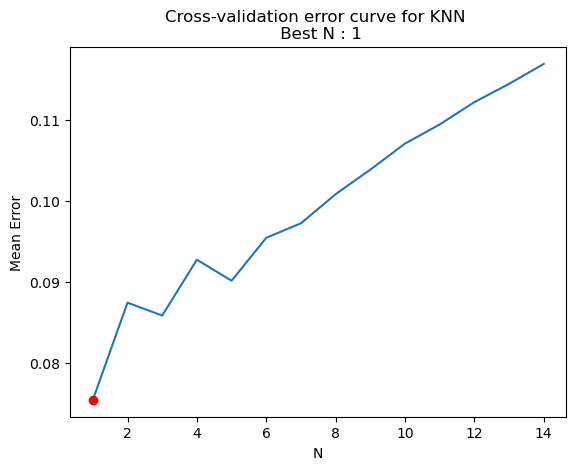

In [67]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
model = KNeighborsClassifier()
neighbors = np.arange(1,15)
params = {'n_neighbors':neighbors}

grid = GridSearchCV(model,
                    param_grid=params,
                    cv=cv,
                    n_jobs=-1
                   )
grid.fit(X_train_resampled, y_train_resampled)
best_n = round(grid.best_params_['n_neighbors'],3)
best_score  = grid.best_score_
print("Best N : {}".format(best_n))
print("Best Score : {}".format(best_score))


#plot
plt.plot(neighbors, 1-grid.cv_results_['mean_test_score'])
plt.plot(best_n,1-best_score,marker="o", color='r')
plt.title("Cross-validation error curve for KNN \n Best N : {}".format(best_n))
plt.xlabel("N")
plt.ylabel("Mean Error")
plt.show()


Accuracy rate from KNN : 0.6630833333333334


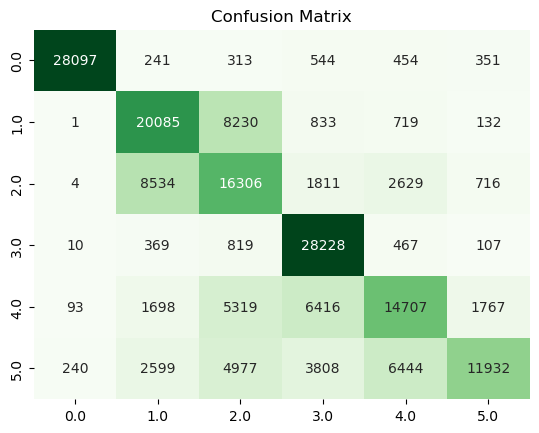

Classification Metrics:
   precision    recall  f1-score  support
0   0.987766  0.936567  0.961485  30000.0
1   0.599087  0.669500  0.632340  30000.0
2   0.453398  0.543533  0.494391  30000.0
3   0.677906  0.940933  0.788051  30000.0
4   0.578560  0.490233  0.530747  30000.0
5   0.795202  0.397733  0.530252  30000.0


In [68]:
# predict using the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_resampled)
knn_accuracy =  accuracy_score(y_test_resampled,y_pred)
print("Accuracy rate from KNN : {}".format(knn_accuracy))

# confusion matrix
cm = confusion_matrix(y_test_resampled,y_pred)
sns.heatmap(cm, 
            annot=True,
            cmap='Greens',
            cbar=False,
            fmt="d",
            xticklabels=np.unique(y_test_resampled),
            yticklabels=np.unique(y_test_resampled)
           )
plt.title("Confusion Matrix")
plt.show()

# calculate classification metrics
df_rpt = pd.DataFrame(precision_recall_fscore_support(y_test_resampled,y_pred)).transpose()
df_rpt.columns = columns=["precision","recall","f1-score","support"]
print("Classification Metrics:")
print(df_rpt)


In [69]:
balanced_acc = balanced_accuracy_score(y_test_resampled, y_pred)

print('Balanced accuracy:', balanced_acc)

Balanced accuracy: 0.6630833333333334


## 2) ensemble method 

In [ ]:
#BalancedRandomForestClassifier is another ensemble method in which each tree of the forest will be provided a balanced bootstrap sample [CLB+04]. 

## fit model in the original dataset

In [70]:

model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
model.fit(scaled_x_train, y_train)
y_pred = model.predict(scaled_x_test)

print('Classification report:\n', classification_report(y_test, y_pred))

C:\Users\stuti\.conda\envs\dvaproject\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\stuti\.conda\envs\dvaproject\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Classification report:
               precision    recall  f1-score   support

         0.0       0.18      0.98      0.30       104
         1.0       0.66      0.79      0.72      4138
         2.0       0.31      0.55      0.39      3671
         3.0       1.00      0.86      0.93     93432
         4.0       0.07      0.51      0.13      1024
         5.0       0.04      0.68      0.07       144

    accuracy                           0.84    102513
   macro avg       0.38      0.73      0.42    102513
weighted avg       0.95      0.84      0.89    102513



In [71]:
#Hyper-parameter Tuning
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


param = {
    'n_estimators': [4, 16, 256],
    'max_depth': [2, 8, 16],
    'sampling_strategy': ['auto', 'all']
}
        
# Perform GridSearchCV
gscv = GridSearchCV(model, param_grid=param, cv=3, scoring='accuracy')
gscv.fit(scaled_x_train, y_train)

# Get the best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_

# Predict using the best model found by GridSearchCV
best_model = gscv.best_estimator_
y_pred = best_model.predict(scaled_x_test)

# Print the classification report
print('Best Parameters:', best_params)
print('Best Score:', best_score)
print('Classification report:\n', classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 2, 'n_estimators': 4, 'sampling_strategy': 'auto'}
Best Score: 0.8604611408719727
Classification report:
               precision    recall  f1-score   support

         0.0       0.03      0.97      0.06       104
         1.0       0.37      0.78      0.51      4138
         2.0       0.32      0.56      0.41      3671
         3.0       1.00      0.89      0.94     93432
         4.0       0.12      0.00      0.01      1024
         5.0       0.01      0.03      0.02       144

    accuracy                           0.87    102513
   macro avg       0.31      0.54      0.32    102513
weighted avg       0.94      0.87      0.89    102513



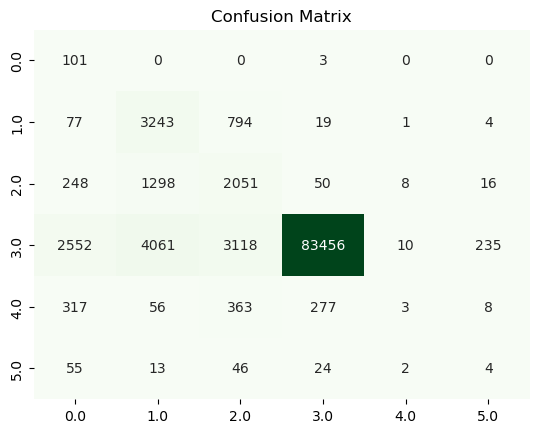

In [72]:
# confusion matrix
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, 
            annot=True,
            cmap='Greens',
            cbar=False,
            fmt="d",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test)
           )
plt.title("Confusion Matrix")
plt.show()


In [73]:

# calculate classification metrics
df_rpt = pd.DataFrame(precision_recall_fscore_support(y_test,y_pred)).transpose()
df_rpt.columns = columns=["precision","recall","f1-score","support"]
print("Classification Metrics:")
print(df_rpt)


Classification Metrics:
   precision    recall  f1-score  support
0   0.030149  0.971154  0.058483    104.0
1   0.374005  0.783712  0.506363   4138.0
2   0.321877  0.558703  0.408444   3671.0
3   0.995550  0.893227  0.941617  93432.0
4   0.125000  0.002930  0.005725   1024.0
5   0.014981  0.027778  0.019465    144.0


In [74]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print('Balanced accuracy:', balanced_acc)

Balanced accuracy: 0.5395839600018728


### fit random forest in resampled (oversampled) dataset

### Hyper-parameter Tuning

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the model
model = RandomForestClassifier()

param = {
    'n_estimators': [4, 16, 64],
    'max_depth': [2, 8, 16]
}

# Perform RandomizedSearchCV with reduced parameter space and fewer iterations
gscv = RandomizedSearchCV(model, param_distributions=param, n_iter=10, cv=3, scoring='accuracy')
gscv.fit(X_train_resampled, y_train_resampled)  # Using a subset of data for faster computation

# Get the best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_

# Predict using the best model found by RandomizedSearchCV
best_model = gscv.best_estimator_
y_pred = best_model.predict(X_test_resampled)  # Using a subset of test data for faster computation

# Print the classification report
print('Best Parameters:', best_params)
print('Best Score:', best_score)
print('Classification report:\n', classification_report(y_test_resampled, y_pred))

C:\Users\stuti\.conda\envs\dvaproject\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 64, 'max_depth': 16}
Best Score: 0.8831444444444445
Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     30000
         1.0       0.76      0.81      0.78     30000
         2.0       0.58      0.66      0.61     30000
         3.0       0.92      0.92      0.92     30000
         4.0       0.62      0.69      0.65     30000
         5.0       0.83      0.60      0.70     30000

    accuracy                           0.77    180000
   macro avg       0.78      0.77      0.77    180000
weighted avg       0.78      0.77      0.77    180000



In [30]:
y_pred[3:]

array([0., 0., 0., ..., 2., 4., 5.])

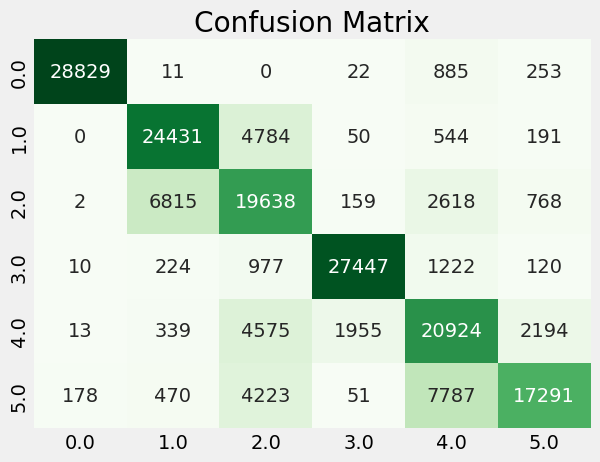

In [104]:
# confusion matrix
cm = confusion_matrix(y_test_resampled,y_pred)
sns.heatmap(cm, 
            annot=True,
            cmap='Greens',
            cbar=False,
            fmt="d",
            xticklabels=np.unique(y_test_resampled),
            yticklabels=np.unique(y_test_resampled)
           )
plt.title("Confusion Matrix")
plt.show()


In [105]:

# calculate classification metrics
df_rpt = pd.DataFrame(precision_recall_fscore_support(y_test_resampled,y_pred)).transpose()
df_rpt.columns = columns=["precision","recall","f1-score","support"]
print("Classification Metrics:")
print(df_rpt)


Classification Metrics:
   precision    recall  f1-score  support
0   0.993008  0.960967  0.976724  30000.0
1   0.756612  0.814367  0.784428  30000.0
2   0.574261  0.654600  0.611804  30000.0
3   0.924640  0.914900  0.919744  30000.0
4   0.615774  0.697467  0.654079  30000.0
5   0.830619  0.576367  0.680520  30000.0


In [80]:
balanced_acc = balanced_accuracy_score(y_test_resampled, y_pred)

print('Balanced accuracy:', balanced_acc)

Balanced accuracy: 0.7719666666666667


## export predicted data for a single day to demo

In [81]:
# Make a copy of the DataFrame df_wo3
df = df_wo3.copy()

# Convert startdate to datetime format
startdate = pd.to_datetime('2023-09-12').date()

# Filter the DataFrame to get rows where 'reportdate' matches the startdate
df_export = df[df['reportdate'].dt.date == startdate]

#print(df_export)

In [82]:
df_export = df_export[[
 'WO Priority',
 'assetcriticality',
 'Labor Hours',
 'Labor Cost',
 'Material Cost',
 'Work Order Cost',
 'assettype_order',
 'WOType_Order',
 'location_order',
 'WO Status_order']]


In [83]:
df_export.shape

(30, 10)

In [84]:
##creating x and y datasets 

x_data = df_export.drop(['WO Priority'], axis=1)
y_data = df_export['WO Priority']

#converting to arrays 

x_data_array = x_data.values
y_data_array = y_data.values

#scaling x data
scaler = StandardScaler()
scaler.fit(x_data_array)
scaled_x_data = scaler.transform(x_data_array)


In [85]:
##predict using the random forest model 'best_model'

y_pred = best_model.predict(scaled_x_data)

# Inverse transform scaled test data to get back the original raw data
original_x_test = scaler.inverse_transform(scaled_x_test)

# Create a DataFrame with predictions and original data
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted_WO_Priority'])  # Creating a DataFrame for predictions
original_x_df = pd.DataFrame(x_data_array, columns=x_data.columns)  

# Concatenate y_pred_df and original_x_df along columns
result_df = pd.concat([y_pred_df, original_x_df.reset_index(drop=True)], axis=1)

# Concatenate actual y data as well 
final_result_df = pd.concat([result_df, y_data.reset_index(drop=True)], axis=1)

# Export result_df to a CSV file or use as needed
final_result_df.to_csv('predictions_with_original_data.csv', index=False)  # Exporting to CSV without index